# SpamDetector

## Preprocessing

In [24]:
#%run ExtractContent.py TR/ TRAIN/

In [25]:
# Get labels
import string
import csv
y = list() # y = labels
with open('spam-mail.tr.label','rb') as f :
    labels_reader = csv.reader(f, delimiter=',')
    count_row = 0

    for row in labels_reader:
        if count_row != 0 :
            y.append(row[1])
        count_row = count_row + 1
        
class_names = ['Spam', 'Ham']
#print y

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get mails
def get_mails(folder_name, prefix) :
    from sklearn.feature_extraction.text import TfidfVectorizer
    import codecs

    from os import listdir
    from os.path import isfile, join
    files = [f for f in listdir(folder_name) if isfile(join(folder_name, f)) and f.endswith('.eml')]
    
    mails = list()
    for i in range(1, len(files) + 1) :
        path = folder_name + '/' + prefix + '_%s.eml'%i
        with codecs.open(path, 'r', encoding='utf-8', errors='ignore') as f :
            mail = f.read()
            mails.append(mail)
    return mails

mails = get_mails('TRAIN', 'TRAIN')

# Compute TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
tfidf_vectorizer.fit(mails) # tfidf_vectorizer remembers the term frequencies and vocabulary that was used to fit it.
X = tfidf_vectorizer.transform(mails)

In [27]:
# Divise dataset
def divide_dataset(X, y) :
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = divide_dataset(X, y)

## Machine Learning

### Tools

In [28]:
# Inspired from : http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #plt.figure()
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    


In [29]:
def k_fold_validation_test() :
    import numpy as np
    from sklearn.model_selection import KFold

    X = ["a", "b", "c", "d"]
    kf = KFold(n_splits=2)
    for train, test in kf.split(X):
        print("%s %s" % (train, test))
k_fold_validation_test() 
    

[2 3] [0 1]
[0 1] [2 3]


In [30]:
def repeated_k_fold_validation_test() :
    import numpy as np
    from sklearn.model_selection import RepeatedKFold
    X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    random_state = 12883823
    rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
    for train, test in rkf.split(X):
        print("%s %s" % (train, test))
repeated_k_fold_validation_test()

[2 3] [0 1]
[0 1] [2 3]
[0 2] [1 3]
[1 3] [0 2]


### Supervised - Decision tree

In [31]:
# Train model
from sklearn import tree
def decision_tree(max_depth) :
    print "Training Decision Tree model..."
    from sklearn import tree

    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth) # classifier = learning algorithm that will learn from the training dataset
    model = clf.fit(X_train, y_train) # finds patterns in training data and create a set of rules (the model)
    print "Model trained!"

    training_error = 1-clf.score(X_train, y_train)
    test_error = 1-clf.score(X_test, y_test)
    print "Training error : " + str(training_error)
    print "Test error : " + str(test_error)
    return model

In [32]:
model = decision_tree(max_depth=1)
y_pred = model.predict(X_test)

Training Decision Tree model...
Model trained!
Training error : 0.162985074627
Test error : 0.153939393939


In [33]:
model = decision_tree(max_depth=7)
y_pred = model.predict(X_test)

Training Decision Tree model...
Model trained!
Training error : 0.0507462686567
Test error : 0.0557575757576


Confusion matrix, without normalization


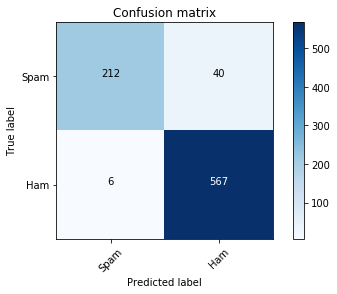

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

### Supervised - SVM

In [35]:
print "Training SVM Model..."
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
print "Model trained!"

training_error = 1-clf.score(X_train, y_train)
test_error = 1-clf.score(X_test, y_test)
print "Training error : " + str(training_error)
print "Test error : " + str(test_error)


Training SVM Model...
Model trained!
Training error : 0.314626865672
Test error : 0.305454545455


# Prediction

In [36]:
#%run ExtractContent.py TT/ TEST/

## For Train/test split

In [41]:
mails = get_mails('TEST', 'TEST')
X_test = tfidf_vectorizer.transform(mails)

# Train again the classifier on the whole datasets (X, y) including testing datasets
# with the best hyper parameters
best_max_depth = 7
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=best_max_depth) # classifier = learning algorithm that will learn from the training dataset
model.fit(X, y)

# Now predict new mails from the TEST dataset (non-labeled)
y_pred = model.predict(X_test)

In [42]:
# Store predicted labels
fd = open('spam-mail.tt.label', 'w')
fd.write('Id,Prediction')

for i in range(0, len(y_pred)):
    fd.write('\n%d,%s' % (i+1, y_pred[i]))

fd.close()


## Parameter tuning using GridSearchCV

In [49]:
from sklearn.model_selection import GridSearchCV
d_range = list(range(1, 31)) # list of parameter values to test
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(max_depth=d_range)

dtc = tree.DecisionTreeClassifier(criterion='entropy')
grid = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy', n_jobs=-1) # Do a 10-fold cross validation
grid.fit(X, y) # fit the grid with data



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [50]:
grid.cv_results_

{'mean_fit_time': array([ 0.45662942,  0.54945803,  0.73135014,  0.62135289,  0.7011029 ,
         0.78910701,  0.83091047,  0.83422079,  1.02273343,  1.06413598,
         1.063884  ,  1.05303657,  1.08398039,  1.16590059,  1.06463373,
         1.14184659,  1.11711512,  1.04021635,  1.01137776,  1.11832607,
         1.49491301,  1.46827443,  1.46522429,  1.44792209,  1.06306329,
         1.08711698,  1.13401637,  1.05583386,  1.07318048,  0.98570518]),
 'mean_score_time': array([ 0.0024579 ,  0.00156107,  0.00214338,  0.0016583 ,  0.00200717,
         0.00182745,  0.0018065 ,  0.00157862,  0.00190847,  0.00194311,
         0.00134149,  0.00203788,  0.0014852 ,  0.00149953,  0.00145161,
         0.001583  ,  0.00174952,  0.00229242,  0.00132005,  0.00218599,
         0.0025408 ,  0.00240667,  0.00176382,  0.00193226,  0.00145209,
         0.00151608,  0.0018882 ,  0.00179381,  0.00146832,  0.0018024 ]),
 'mean_test_score': array([ 0.84  ,  0.8516,  0.8996,  0.9288,  0.9292,  0.9336,  0.

In [47]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9592
{'max_depth': 27}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=27,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
